# 2. Data Understanding
CDC Diabetes Health Indicators Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, kruskal, spearmanr
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 2.1 Collect Initial Data

In [2]:
df = pd.read_csv('CDC Diabetes Dataset (4).csv')
print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"Source: CDC Behavioral Risk Factor Surveillance System (BRFSS)")

Dataset: 253,680 rows, 22 columns
Source: CDC Behavioral Risk Factor Surveillance System (BRFSS)


The dataset contains 253,680 telephone survey responses with 22 variables (21 predictors, 1 target). The data is pre-cleaned, numerically encoded, and free of missing values.

### 2.1.1 Data Consistency Checks
Checking for duplicate entries and missing values to ensure data integrity.

In [3]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows found: {duplicates:,}")
print(f"Percentage of duplicates: {duplicates/len(df):.1%}")

Duplicate rows found: 23,899
Percentage of duplicates: 9.4%


**Note on Duplicates:**
While duplicates exist, they are expected in this dataset. The survey consists of mostly categorical/binary variables with limited unique combinations. Two individuals having the exact same responses (e.g., same age group, same health flags) is statistically probable and represents genuine population clusters rather than data entry errors. We retain them to preserve the distribution weights.

In [4]:
# Check for missing values
missing_values = df.isnull().sum().sum()
print(f"Total missing values: {missing_values}")

Total missing values: 0


## 2.2 Describe Data

In [5]:
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [6]:
df.dtypes

Diabetes_012            float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object

All variables are stored as float64 but most are categorical or ordinal. The numeric pre-encoding means no text-to-numeric conversion is needed, but variables must be treated according to their true type in analysis.

In [7]:
# Categorize features by type
target = 'Diabetes_012'

# Define based on domain knowledge
binary_features = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 
                   'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
                   'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']
ordinal_features = ['GenHlth', 'Age', 'Education', 'Income']
count_features = ['MentHlth', 'PhysHlth']  # Days in last 30
continuous_features = ['BMI']

print(f"Binary: {len(binary_features)}, Ordinal: {len(ordinal_features)}, Count: {len(count_features)}, Continuous: {len(continuous_features)}")

Binary: 14, Ordinal: 4, Count: 2, Continuous: 1


The 21 predictors comprise 14 binary (yes/no), 4 ordinal (ranked categories), 2 count (days in last 30), and 1 continuous (BMI). Standard summary statistics are only appropriate for BMI; proportions and medians are more meaningful for binary and ordinal variables respectively.

### Feature Encoding Reference

**Binary features (0=No, 1=Yes):**
| Feature | 0 | 1 |
|---------|---|---|
| HighBP | No high BP | Has high blood pressure |
| HighChol | No high cholesterol | Has high cholesterol |
| CholCheck | No check in 5 years | Had cholesterol check |
| Smoker | <100 cigarettes lifetime | Smoked ≥100 cigarettes |
| Stroke | No stroke | Has had a stroke |
| HeartDiseaseorAttack | No CHD/MI | Has CHD or MI |
| PhysActivity | No activity in 30 days | Physically active |
| Fruits | No daily fruit | Consumes fruit ≥1/day |
| Veggies | No daily vegetables | Consumes veg ≥1/day |
| HvyAlcoholConsump | Not heavy drinker | Heavy drinker |
| AnyHealthcare | No coverage | Has health insurance |
| NoDocbcCost | Could afford doctor | Couldn't afford doctor |
| DiffWalk | No difficulty | Difficulty walking |
| Sex | Female | Male |

**Ordinal features:**
- GenHlth: 1=Excellent, 2=Very Good, 3=Good, 4=Fair, 5=Poor
- Age: 1=18-24, 2=25-29, ... 13=80+
- Education: 1=No school, 2=Elementary, 3=Some HS, 4=HS Grad, 5=Some College, 6=College Grad
- Income: 1=<$10k, 2=$10-15k, 3=$15-20k, 4=$20-25k, 5=$25-35k, 6=$35-50k, 7=$50-75k, 8=$75k+

**Count features:** MentHlth, PhysHlth = days of poor health in last 30 days (0-30)

In [8]:
# Binary features summary
print("BINARY FEATURES")
print(f"{'Feature':<22} {'n(0)':>9} {'n(1)':>9} {'%(1)':>7} {'Missing':>7}")
print("-"*60)

for feat in binary_features:
    n0 = (df[feat] == 0).sum()
    n1 = (df[feat] == 1).sum()
    pct1 = n1 / len(df)
    miss = df[feat].isnull().sum()
    print(f"{feat:<22} {n0:>9,} {n1:>9,} {pct1:>7.1%} {miss:>7}")

BINARY FEATURES
Feature                     n(0)      n(1)    %(1) Missing
------------------------------------------------------------
HighBP                   144,851   108,829   42.9%       0
HighChol                 146,089   107,591   42.4%       0
CholCheck                  9,470   244,210   96.3%       0
Smoker                   141,257   112,423   44.3%       0
Stroke                   243,388    10,292    4.1%       0
HeartDiseaseorAttack     229,787    23,893    9.4%       0
PhysActivity              61,760   191,920   75.7%       0
Fruits                    92,782   160,898   63.4%       0
Veggies                   47,839   205,841   81.1%       0
HvyAlcoholConsump        239,424    14,256    5.6%       0
AnyHealthcare             12,417   241,263   95.1%       0
NoDocbcCost              232,326    21,354    8.4%       0
DiffWalk                 211,005    42,675   16.8%       0
Sex                      141,974   111,706   44.0%       0


Key observations:
- **High prevalence**: CholCheck (96%), AnyHealthcare (95%), PhysActivity (76%) — most respondents have healthcare access and report healthy behaviours
- **Metabolic risk**: HighBP (43%) and HighChol (42%) affect nearly half the sample
- **Low prevalence**: Stroke (4%), HvyAlcoholConsump (6%), HeartDiseaseorAttack (9%)
- **Sex**: 44% male, 56% female (0 = Female, 1 = Male)

In [9]:
# Ordinal features summary
ordinal_labels = {
    'GenHlth': {1: 'Excellent', 2: 'Very Good', 3: 'Good', 4: 'Fair', 5: 'Poor'},
    'Age': {1: '18-24', 2: '25-29', 3: '30-34', 4: '35-39', 5: '40-44', 6: '45-49', 
            7: '50-54', 8: '55-59', 9: '60-64', 10: '65-69', 11: '70-74', 12: '75-79', 13: '80+'},
    'Education': {1: 'No school', 2: 'Elementary', 3: 'Some HS', 4: 'HS Grad', 5: 'Some College', 6: 'College Grad'},
    'Income': {1: '<$10k', 2: '$10-15k', 3: '$15-20k', 4: '$20-25k', 5: '$25-35k', 6: '$35-50k', 7: '$50-75k', 8: '$75k+'}
}

print("ORDINAL FEATURES")
print(f"{'Feature':<12} {'Range':>10} {'Median':>8} {'Meaning':<15} {'Mode':>6} {'Meaning':<15}")
print("-"*75)

for feat in ordinal_features:
    med = int(df[feat].median())
    mode = int(df[feat].mode()[0])
    med_lbl = ordinal_labels[feat].get(med, str(med))
    mode_lbl = ordinal_labels[feat].get(mode, str(mode))
    print(f"{feat:<12} {int(df[feat].min())}-{int(df[feat].max()):>6} {med:>8} {med_lbl:<15} {mode:>6} {mode_lbl:<15}")

ORDINAL FEATURES
Feature           Range   Median Meaning           Mode Meaning        
---------------------------------------------------------------------------
GenHlth      1-     5        2 Very Good            2 Very Good      
Age          1-    13        8 55-59                9 60-64          
Education    1-     6        5 Some College         6 College Grad   
Income       1-     8        7 $50-75k              8 $75k+          


The sample skews older (median age group 55-59), more educated (mode = College Grad), and higher income (mode = $75k+). This likely reflects BRFSS telephone survey methodology and should be considered when generalising findings.

In [10]:
# Count and continuous features
print("COUNT FEATURES (days of poor health in last 30)")
for feat in count_features:
    pct_zero = (df[feat] == 0).mean()
    pct_thirty = (df[feat] == 30).mean()
    print(f"{feat}: median={int(df[feat].median())}, mean={df[feat].mean():.1f}, {pct_zero:.1%} report 0 days, {pct_thirty:.1%} report 30 days")

print("\nCONTINUOUS FEATURES")
for feat in continuous_features:
    print(f"{feat}: mean={df[feat].mean():.1f}, median={df[feat].median():.1f}, std={df[feat].std():.1f}, range={df[feat].min():.0f}-{df[feat].max():.0f}")

COUNT FEATURES (days of poor health in last 30)
MentHlth: median=0, mean=3.2, 69.3% report 0 days, 4.8% report 30 days
PhysHlth: median=0, mean=4.2, 63.1% report 0 days, 7.6% report 30 days

CONTINUOUS FEATURES
BMI: mean=28.4, median=27.0, std=6.6, range=12-98


- **MentHlth/PhysHlth**: Zero-inflated — most respondents report 0 poor days, with a minority reporting 30 (chronic). These characteristics inform later binning decisions.
- **BMI**: Mean 28.4 (overweight), range 12-98. Positive skew is expected; extreme values are retained as downstream models use categorical binning.

## 2.3 Explore Data

### 2.3.1 Target Variable

Target distribution:
  0.0 (No Diabetes): 213,703 (84.2%)
  1.0 (Prediabetes): 4,631 (1.8%)
  2.0 (Diabetes): 35,346 (13.9%)


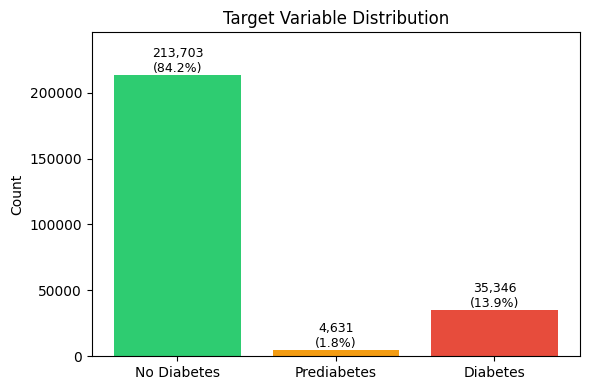

In [11]:
target_counts = df[target].value_counts().sort_index()
target_props = df[target].value_counts(normalize=True).sort_index()

print("Target distribution:")
for val, cnt, prop in zip(target_counts.index, target_counts.values, target_props.values):
    label = {0: 'No Diabetes', 1: 'Prediabetes', 2: 'Diabetes'}[val]
    print(f"  {val} ({label}): {cnt:,} ({prop:.1%})")

fig, ax = plt.subplots(figsize=(6, 4))
colors = ['#2ecc71', '#f39c12', '#e74c3c']
bars = ax.bar(['No Diabetes', 'Prediabetes', 'Diabetes'], target_counts.values, color=colors)
ax.set_ylabel('Count')
ax.set_title('Target Variable Distribution')
for bar, cnt, prop in zip(bars, target_counts.values, target_props.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{cnt:,}\n({prop:.1%})', 
            ha='center', va='bottom', fontsize=9)
ax.set_ylim(0, max(target_counts.values) * 1.15)
plt.tight_layout()
plt.show()

**Severe class imbalance**: No Diabetes (84.2%), Diabetes (13.9%), Prediabetes (1.8%). The extreme underrepresentation of prediabetes relative to estimated population prevalence (~30%) suggests underdiagnosis. A naive majority-class classifier would achieve 84% accuracy, making accuracy a misleading metric. This necessitates stratified sampling, imbalance-handling techniques, and macro-averaged evaluation metrics.

### 2.3.2 Feature Correlations

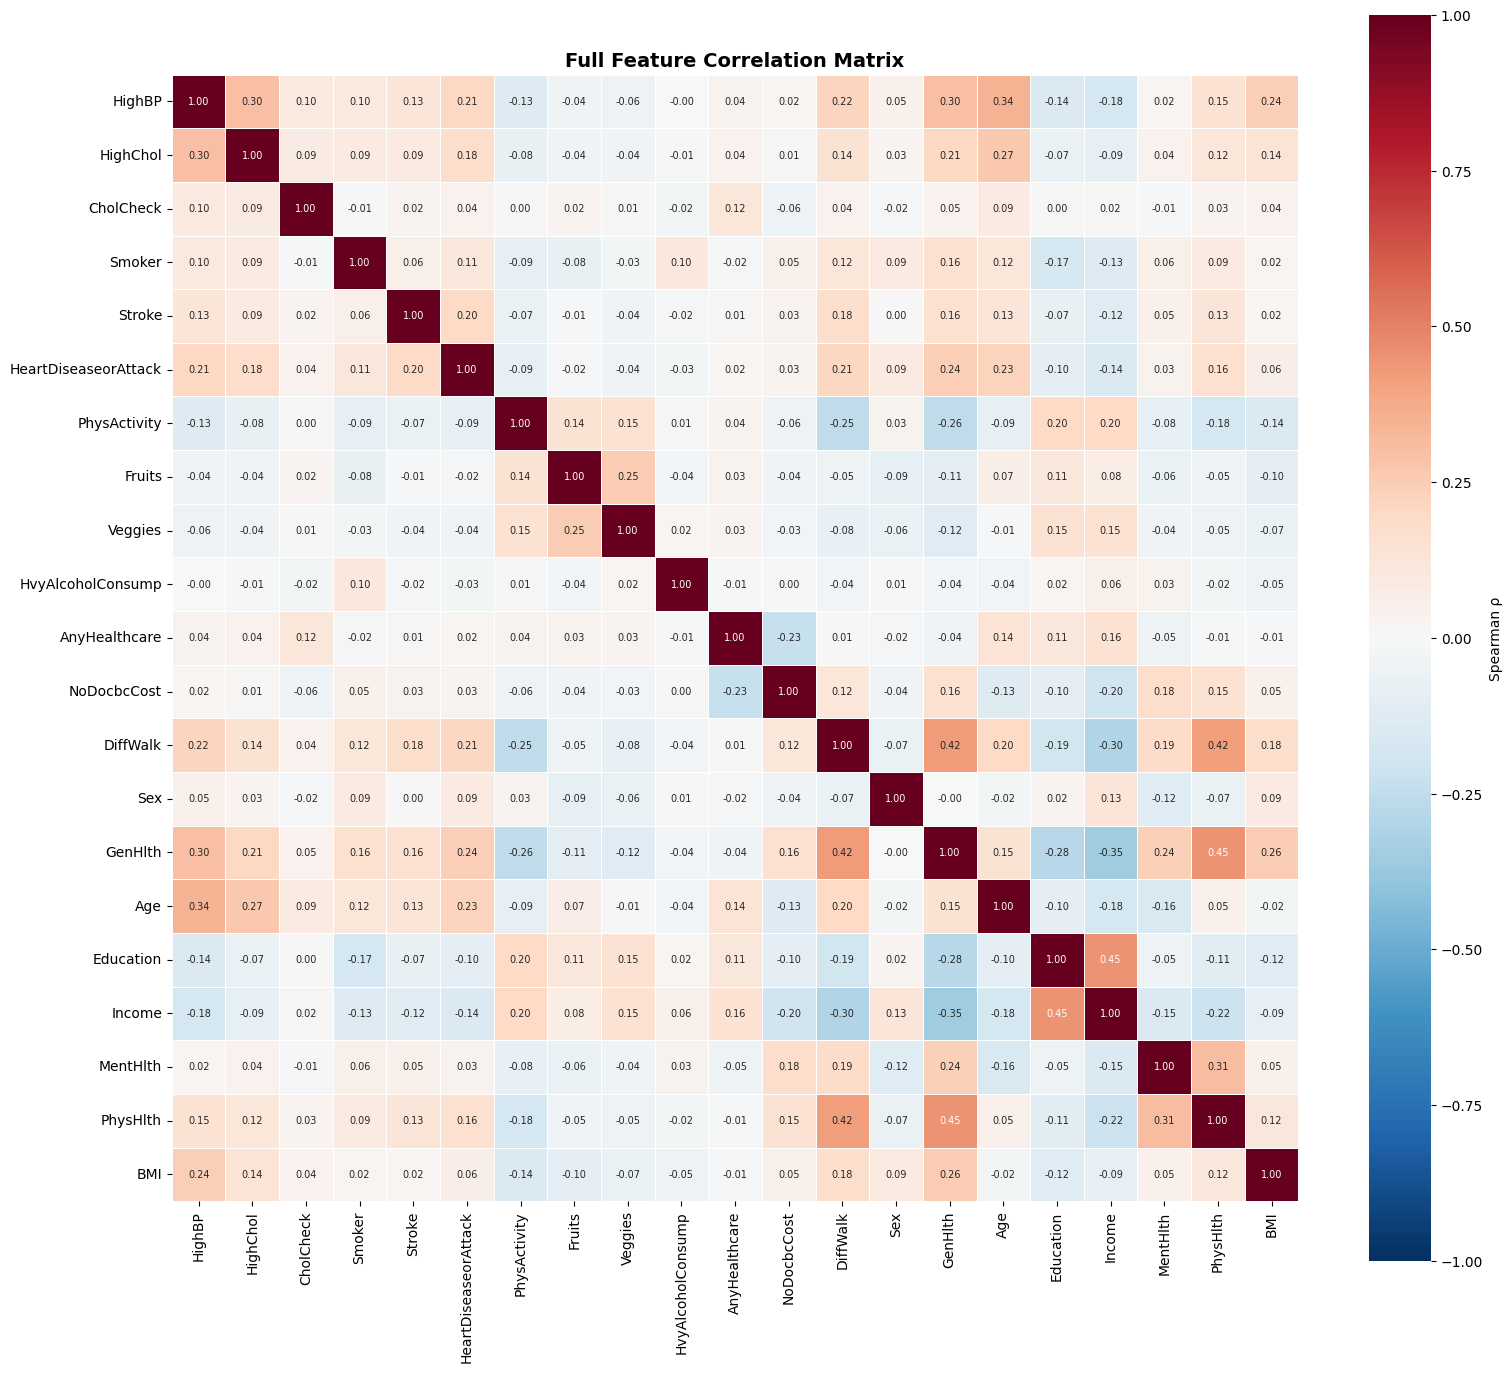

In [12]:
all_features = binary_features + ordinal_features + count_features + continuous_features

# 1. Full correlation matrix heatmap
feature_corr = df[all_features].corr(method='spearman')

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(feature_corr, cmap='RdBu_r', center=0, square=True,
            vmin=-1, vmax=1, linewidths=0.5, annot=True, fmt='.2f',
            annot_kws={'size': 7}, cbar_kws={'label': 'Spearman ρ'})
ax.set_title('Full Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

The full correlation matrix shows the pairwise Spearman correlations between all features. Notable clusters of correlation are visible, which we will examine for collinearity after looking at correlations with the target.

CORRELATION WITH TARGET (Spearman) + Statistical Significance
Feature                 Correlation        p-value  Significant
-----------------------------------------------------------------
HighBP                        0.272       0.00e+00       Yes***
HighChol                      0.211       0.00e+00       Yes***
CholCheck                     0.068      8.43e-258       Yes***
Smoker                        0.063      1.12e-221       Yes***
Stroke                        0.106       0.00e+00       Yes***
HeartDiseaseorAttack          0.179       0.00e+00       Yes***
PhysActivity                 -0.122       0.00e+00       Yes***
Fruits                       -0.042      1.18e-100       Yes***
Veggies                      -0.059      1.06e-196       Yes***
HvyAlcoholConsump            -0.057      4.33e-183       Yes***
AnyHealthcare                 0.015       2.50e-13       Yes***
NoDocbcCost                   0.037       4.06e-79       Yes***
DiffWalk                      0.224     

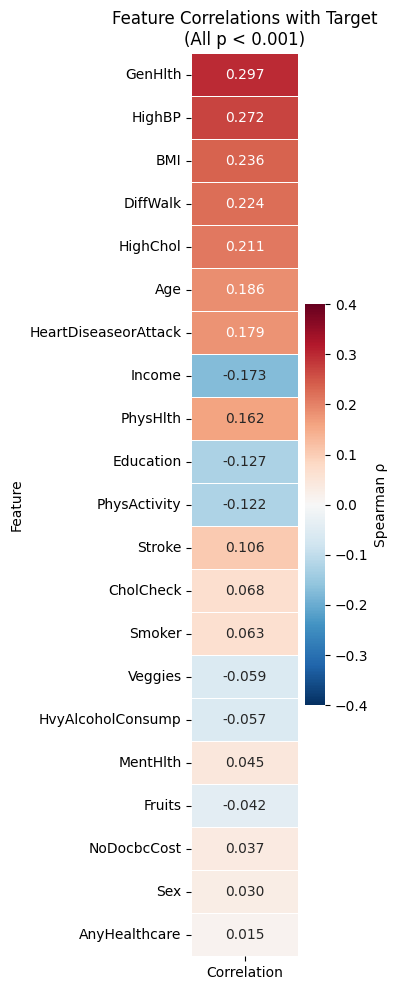

In [13]:
# 2. Correlation with target + statistical significance
print("CORRELATION WITH TARGET (Spearman) + Statistical Significance")
print(f"{'Feature':<22} {'Correlation':>12} {'p-value':>14} {'Significant':>12}")
print("-"*65)

target_corrs = []
for feat in all_features:
    corr, p_value = spearmanr(df[feat], df[target])
    sig = "Yes***" if p_value < 0.001 else "Yes**" if p_value < 0.01 else "Yes*" if p_value < 0.05 else "No"
    target_corrs.append({'Feature': feat, 'Correlation': corr, 'p_value': p_value, 'Significant': sig})
    print(f"{feat:<22} {corr:>12.3f} {p_value:>14.2e} {sig:>12}")

print("\n*** p<0.001, ** p<0.01, * p<0.05")

target_corr_df = pd.DataFrame(target_corrs).sort_values('Correlation', key=abs, ascending=False)

# Heatmap of correlations with target
fig, ax = plt.subplots(figsize=(4, 10))
corr_matrix = target_corr_df.set_index('Feature')[['Correlation']]
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            vmin=-0.4, vmax=0.4, cbar_kws={'label': 'Spearman ρ'},
            linewidths=0.5, ax=ax)
ax.set_title('Feature Correlations with Target\n(All p < 0.001)')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

All features show statistically significant correlations with the target (p < 0.001), though effect sizes are mostly weak to moderate. Predictive signal is concentrated in a small subset of variables:

| Strength | ρ Range | Features |
|----------|---------|----------|
| Moderate | 0.20 – 0.30 | GenHlth (0.297), HighBP (0.272), BMI (0.236), DiffWalk (0.224), HighChol (0.211) |
| Weak | 0.10 – 0.20 | Age (0.186), HeartDiseaseorAttack (0.179), Income (−0.173), PhysHlth (0.162), Education (−0.127), PhysActivity (−0.122), Stroke (0.106) |
| Very weak | < 0.10 | CholCheck (0.068), Smoker (0.063), Veggies (−0.059), HvyAlcoholConsump (−0.057), MentHlth (0.045), Fruits (−0.042), NoDocbcCost (0.037), Sex (0.030), AnyHealthcare (0.015) |

In [14]:
# 2b. Chi-squared tests (binary features) and Kruskal-Wallis tests (ordinal/continuous)
# ─────────────────────────────────────────────────────────────────────────────

def cramers_v(contingency_table):
    """Compute Cramér's V effect size from a contingency table."""
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    return np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0.0

print("CHI-SQUARED TESTS – Binary features vs Diabetes_012")
print(f"{'Feature':<22} {'χ²':>12} {'p-value':>14} {'Cramér V':>10} {'Effect':>10}")
print("-" * 72)

chi2_results = []
for feat in binary_features:
    ct = pd.crosstab(df[feat], df[target])
    chi2_stat, p, dof, _ = chi2_contingency(ct)
    v = cramers_v(ct)
    effect = "Small" if v < 0.10 else "Medium" if v < 0.30 else "Large"
    chi2_results.append({'Feature': feat, 'Chi2': chi2_stat, 'p_value': p, 'Cramers_V': v, 'Effect': effect})
    print(f"{feat:<22} {chi2_stat:>12,.1f} {p:>14.2e} {v:>10.3f} {effect:>10}")

print("\n")
print("KRUSKAL-WALLIS TESTS – Ordinal / continuous features vs Diabetes_012")
print(f"{'Feature':<22} {'H-statistic':>12} {'p-value':>14} {'η² (effect)':>14} {'Effect':>10}")
print("-" * 76)

kw_results = []
for feat in ordinal_features + count_features + continuous_features:
    groups = [grp[feat].values for _, grp in df.groupby(target)]
    h_stat, p = kruskal(*groups)
    # Epsilon-squared (η²_H) approximation for Kruskal-Wallis
    n = len(df)
    eta2 = (h_stat - len(groups) + 1) / (n - len(groups))
    effect = "Small" if eta2 < 0.01 else "Medium" if eta2 < 0.06 else "Large"
    kw_results.append({'Feature': feat, 'H': h_stat, 'p_value': p, 'eta2': eta2, 'Effect': effect})
    print(f"{feat:<22} {h_stat:>12,.1f} {p:>14.2e} {eta2:>14.4f} {effect:>10}")

print("\nNote: Effect-size thresholds – Cramér's V: Small <0.10, Medium 0.10-0.30, Large >0.30")
print("      η² (epsilon-squared): Small <0.01, Medium 0.01-0.06, Large >0.06")

CHI-SQUARED TESTS – Binary features vs Diabetes_012
Feature                          χ²        p-value   Cramér V     Effect
------------------------------------------------------------------------
HighBP                     18,794.6       0.00e+00      0.272     Medium
HighChol                   11,258.9       0.00e+00      0.211     Medium
CholCheck                   1,173.7      1.33e-255      0.068      Small
Smoker                      1,010.5      3.72e-220      0.063      Small
Stroke                      2,916.8       0.00e+00      0.107     Medium
HeartDiseaseorAttack        8,244.9       0.00e+00      0.180     Medium
PhysActivity                3,789.3       0.00e+00      0.122     Medium
Fruits                        454.3       2.19e-99      0.042      Small
Veggies                       893.8      8.03e-195      0.059      Small
HvyAlcoholConsump             850.3      2.26e-185      0.058      Small
AnyHealthcare                  69.1       1.00e-15      0.017      Small

With n = 253,680, statistical significance is trivially achieved (all p ≈ 0). Effect sizes are what matter: Cramér's V (binary) and epsilon-squared η² (ordinal/continuous) confirm that practical predictive power is concentrated in GenHlth, HighBP, BMI, DiffWalk, HighChol, and Age. The remaining features contribute weak but potentially additive signal.

In [15]:
# 3. Collinearity check - identify highly correlated feature pairs
print("COLLINEARITY CHECK")
print("Feature pairs with |correlation| > 0.3:")
print(f"{'Feature 1':<22} {'Feature 2':<22} {'Correlation':>12}")
print("-"*60)

collinear_pairs = []
for i in range(len(feature_corr.columns)):
    for j in range(i+1, len(feature_corr.columns)):
        corr = feature_corr.iloc[i, j]
        if abs(corr) > 0.3:
            collinear_pairs.append({
                'Feature 1': feature_corr.columns[i],
                'Feature 2': feature_corr.columns[j],
                'Correlation': corr
            })
            print(f"{feature_corr.columns[i]:<22} {feature_corr.columns[j]:<22} {corr:>12.3f}")

if not collinear_pairs:
    print("No highly correlated feature pairs found.")
else:
    print(f"\nTotal pairs with |ρ| > 0.3: {len(collinear_pairs)}")

COLLINEARITY CHECK
Feature pairs with |correlation| > 0.3:
Feature 1              Feature 2               Correlation
------------------------------------------------------------
HighBP                 GenHlth                       0.303
HighBP                 Age                           0.345
DiffWalk               GenHlth                       0.423
DiffWalk               Income                       -0.304
DiffWalk               PhysHlth                      0.415
GenHlth                Income                       -0.354
GenHlth                PhysHlth                      0.452
Education              Income                        0.452
MentHlth               PhysHlth                      0.308

Total pairs with |ρ| > 0.3: 9


Several feature pairs show moderate collinearity (|ρ| > 0.3), indicating overlapping information that may reduce the stability of linear models. This is mitigated through feature engineering and the use of tree-based methods.

| Feature 1 | Feature 2 | Spearman ρ |
|-----------|-----------|-----------|
| GenHlth | PhysHlth | 0.452 |
| Education | Income | 0.452 |
| DiffWalk | GenHlth | 0.423 |
| DiffWalk | PhysHlth | 0.415 |
| GenHlth | Income | −0.354 |
| HighBP | Age | 0.345 |
| MentHlth | PhysHlth | 0.308 |
| DiffWalk | Income | −0.304 |
| HighBP | GenHlth | 0.303 |

### 2.3.3 Diabetes Rates by Feature

To understand the practical impact of each feature, we examine the diabetes prevalence (% with diabetes) within each feature category.

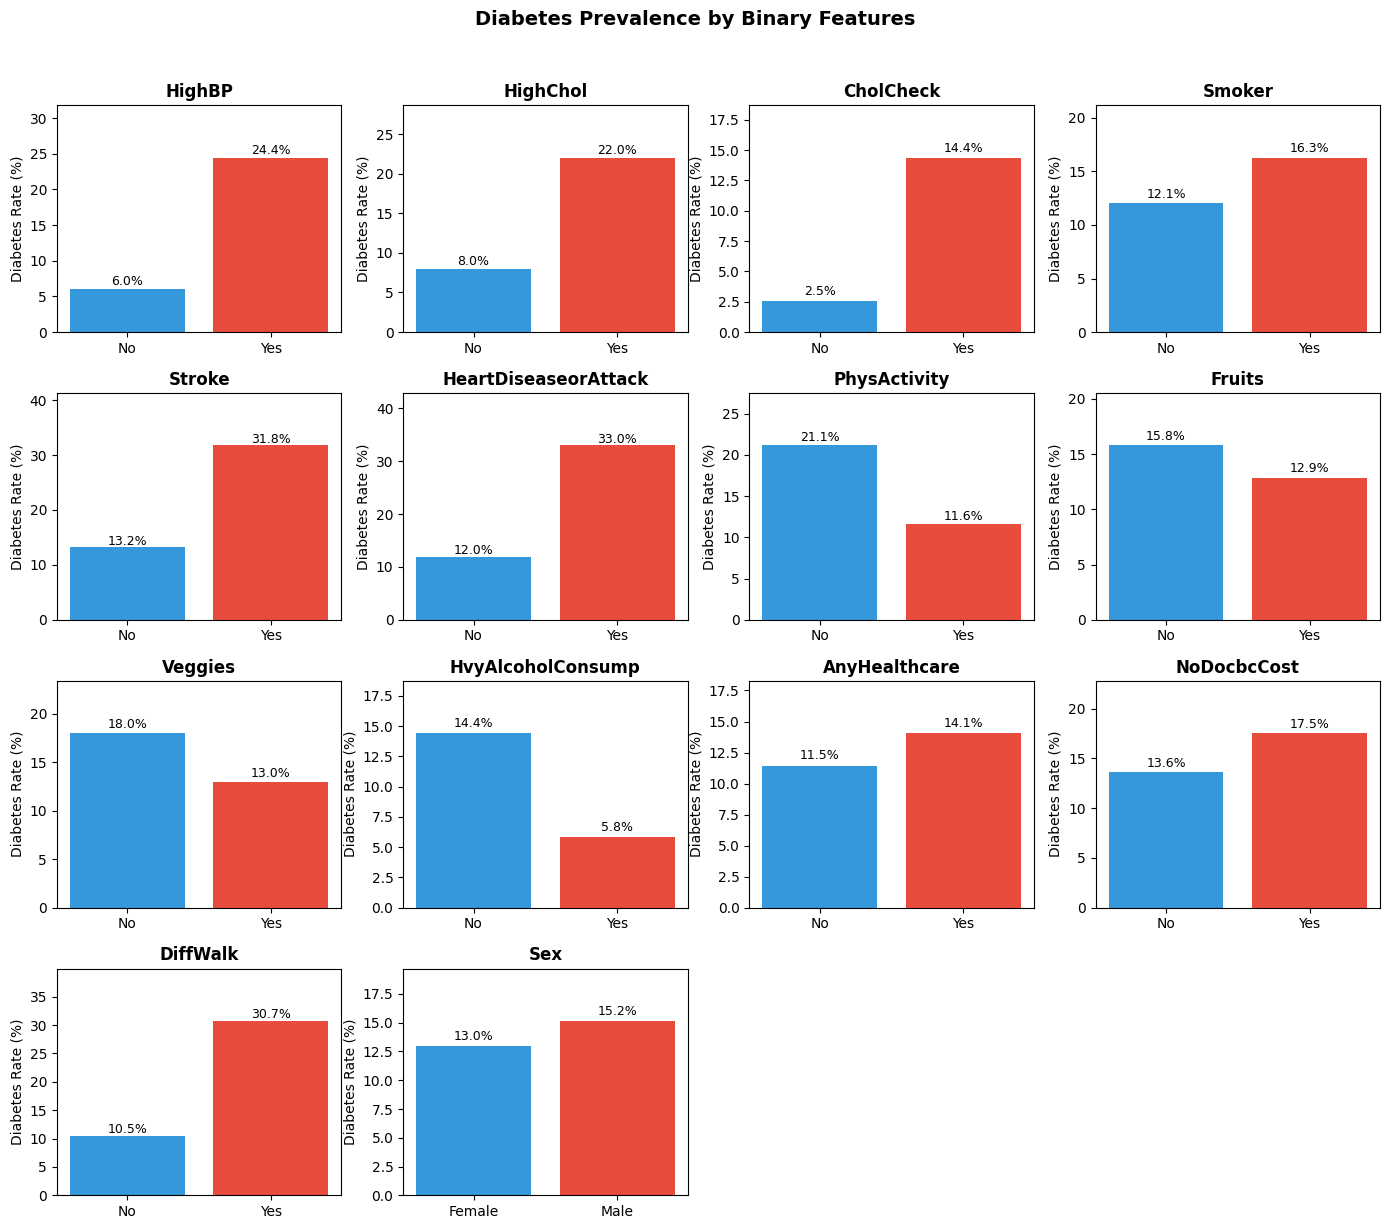

In [16]:
# Diabetes rates by binary features
fig, axes = plt.subplots(4, 4, figsize=(14, 12))
axes = axes.ravel()

# Custom labels for Sex (0=Female, 1=Male per BRFSS codebook)
label_map = {'Sex': ['Female', 'Male']}

for idx, feat in enumerate(binary_features):
    ax = axes[idx]
    
    # Calculate diabetes rate (target == 2) for each group
    rate_0 = (df[df[feat] == 0][target] == 2).mean() * 100
    rate_1 = (df[df[feat] == 1][target] == 2).mean() * 100
    
    labels = label_map.get(feat, ['No', 'Yes'])
    bars = ax.bar(labels, [rate_0, rate_1], color=['#3498db', '#e74c3c'])
    ax.set_ylabel('Diabetes Rate (%)')
    ax.set_title(feat, fontweight='bold')
    ax.set_ylim(0, max(rate_0, rate_1) * 1.3)
    
    # Add value labels
    for bar, rate in zip(bars, [rate_0, rate_1]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{rate:.1f}%', ha='center', fontsize=9)

# Hide unused subplots
for idx in range(len(binary_features), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Diabetes Prevalence by Binary Features', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Strong risk factors**: HighBP (3.3x), HighChol (3x), DiffWalk (3x), HeartDiseaseorAttack, Stroke — metabolic and vascular conditions cluster with diabetes.

**Protective factors**: PhysActivity (18.3% vs 12.5%), Fruits/Veggies (modest ~2% difference).

**Weak/counterintuitive**: Sex shows minimal difference. HvyAlcoholConsump shows lower diabetes rates among heavy drinkers — likely survivorship bias rather than a protective effect. Stroke and HeartDiseaseorAttack are flagged as potential reverse causality (consequences rather than predictors).

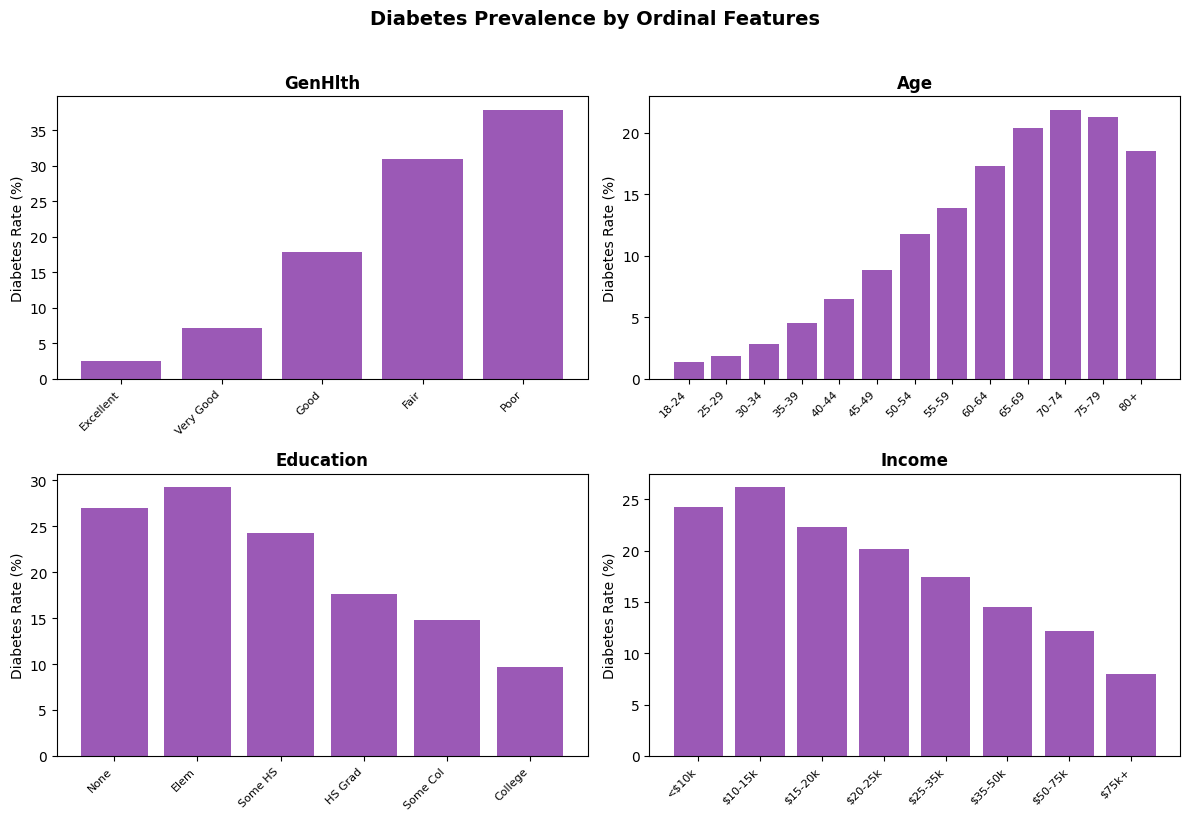

In [17]:
# Diabetes rates by ordinal features
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

ordinal_xlabels = {
    'GenHlth': ['Excellent', 'Very Good', 'Good', 'Fair', 'Poor'],
    'Age': ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+'],
    'Education': ['None', 'Elem', 'Some HS', 'HS Grad', 'Some Col', 'College'],
    'Income': ['<$10k', '$10-15k', '$15-20k', '$20-25k', '$25-35k', '$35-50k', '$50-75k', '$75k+']
}

for idx, feat in enumerate(ordinal_features):
    ax = axes[idx]
    
    # Calculate diabetes rate for each category
    categories = sorted(df[feat].unique())
    rates = [(df[df[feat] == cat][target] == 2).mean() * 100 for cat in categories]
    
    bars = ax.bar(range(len(categories)), rates, color='#9b59b6')
    ax.set_ylabel('Diabetes Rate (%)')
    ax.set_title(feat, fontweight='bold')
    ax.set_xticks(range(len(categories)))
    
    # Use labels if available
    if feat in ordinal_xlabels:
        labels = ordinal_xlabels[feat][:len(categories)]
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    else:
        ax.set_xticklabels([int(c) for c in categories])

plt.suptitle('Diabetes Prevalence by Ordinal Features', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

- **GenHlth**: Clear monotonic relationship — diabetes rate increases from ~3% (Excellent) to ~35% (Poor). Strongest individual predictor.
- **Age**: Strong positive trend — ~1% (18-24) to ~20% (65-69), with slight decline in 80+ (survivorship bias).
- **Education/Income**: Inverse relationships — higher SES associated with lower diabetes rates, reflecting health disparities.

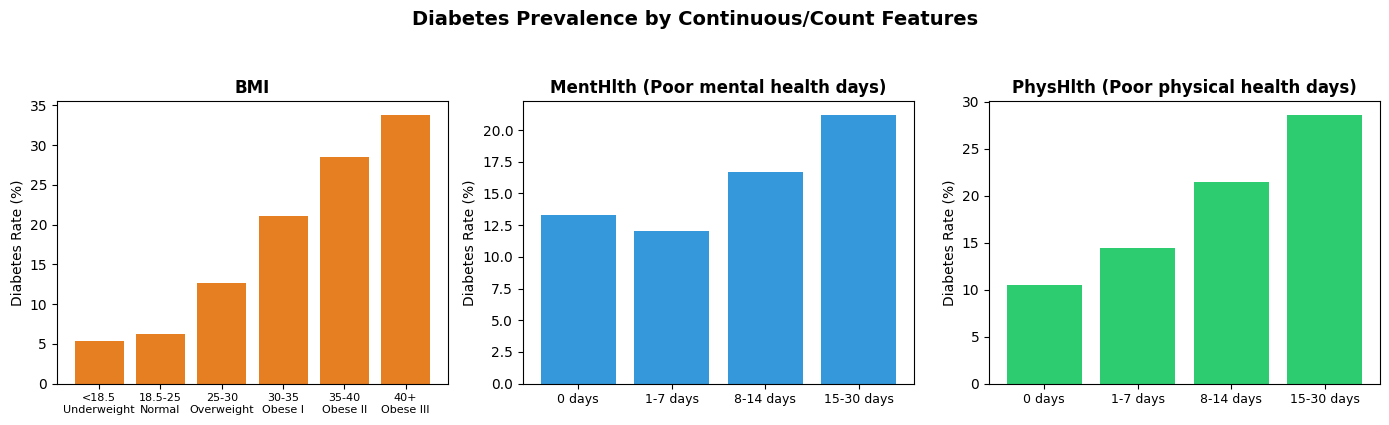

In [18]:
# Diabetes rates by continuous/count features (binned)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# BMI - binned into categories
bmi_bins = [0, 18.5, 25, 30, 35, 40, 100]
bmi_labels = ['<18.5\nUnderweight', '18.5-25\nNormal', '25-30\nOverweight', '30-35\nObese I', '35-40\nObese II', '40+\nObese III']
df['BMI_cat'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels)

bmi_rates = df.groupby('BMI_cat', observed=True).apply(lambda x: (x[target] == 2).mean() * 100)
axes[0].bar(range(len(bmi_rates)), bmi_rates.values, color='#e67e22')
axes[0].set_xticks(range(len(bmi_rates)))
axes[0].set_xticklabels(bmi_labels, fontsize=8)
axes[0].set_ylabel('Diabetes Rate (%)')
axes[0].set_title('BMI', fontweight='bold')

# MentHlth - binned
mental_bins = [0, 1, 7, 14, 30]
mental_labels = ['0 days', '1-7 days', '8-14 days', '15-30 days']
df['MentHlth_cat'] = pd.cut(df['MentHlth'], bins=[-1, 0, 7, 14, 30], labels=mental_labels)

mental_rates = df.groupby('MentHlth_cat', observed=True).apply(lambda x: (x[target] == 2).mean() * 100)
axes[1].bar(range(len(mental_rates)), mental_rates.values, color='#3498db')
axes[1].set_xticks(range(len(mental_rates)))
axes[1].set_xticklabels(mental_labels, fontsize=9)
axes[1].set_ylabel('Diabetes Rate (%)')
axes[1].set_title('MentHlth (Poor mental health days)', fontweight='bold')

# PhysHlth - binned
df['PhysHlth_cat'] = pd.cut(df['PhysHlth'], bins=[-1, 0, 7, 14, 30], labels=mental_labels)

phys_rates = df.groupby('PhysHlth_cat', observed=True).apply(lambda x: (x[target] == 2).mean() * 100)
axes[2].bar(range(len(phys_rates)), phys_rates.values, color='#2ecc71')
axes[2].set_xticks(range(len(phys_rates)))
axes[2].set_xticklabels(mental_labels, fontsize=9)
axes[2].set_ylabel('Diabetes Rate (%)')
axes[2].set_title('PhysHlth (Poor physical health days)', fontweight='bold')

# Clean up temporary columns
df.drop(['BMI_cat', 'MentHlth_cat', 'PhysHlth_cat'], axis=1, inplace=True)

plt.suptitle('Diabetes Prevalence by Continuous/Count Features', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

- **BMI**: Clear dose-response — normal BMI (~6% diabetes) to obese class III (~30%, 5x higher risk). Major modifiable risk factor.
- **MentHlth/PhysHlth**: Positive relationships with diabetes. Zero-inflated distributions dominated by 0 days, with a chronic tail at 30 days.

### 2.3.4 Advanced Visualisations
Exploring relationships between key risk factors and Diabetes.

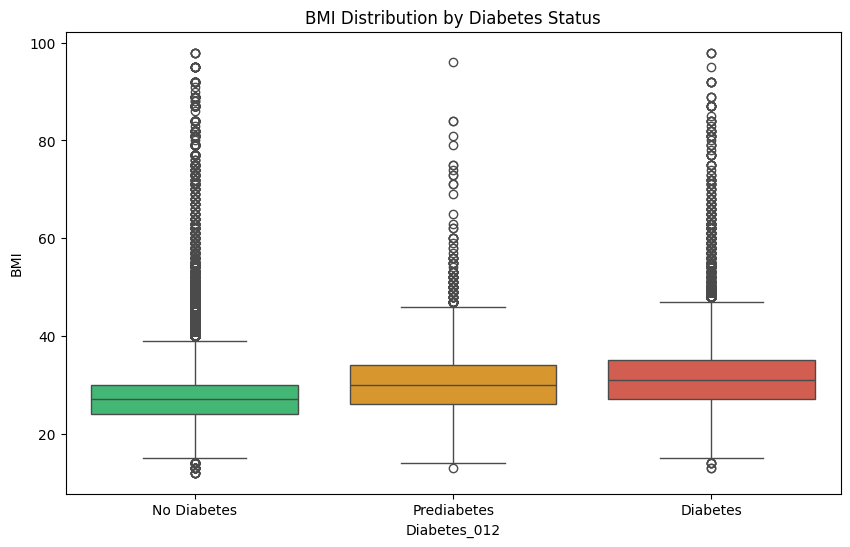

In [19]:
# BMI Distribution by Diabetes Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Diabetes_012', y='BMI', data=df, palette=['#2ecc71', '#f39c12', '#e74c3c'])
plt.title('BMI Distribution by Diabetes Status')
plt.xticks([0, 1, 2], ['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.show()

**Interpretation:**
The boxplot clearly shows that the median BMI is higher for the Diabetic group compared to the Non-Diabetic group. There are significant outliers in the BMI distribution, but the interquartile range shifts upwards with diabetes severity.

<Figure size 1000x600 with 0 Axes>

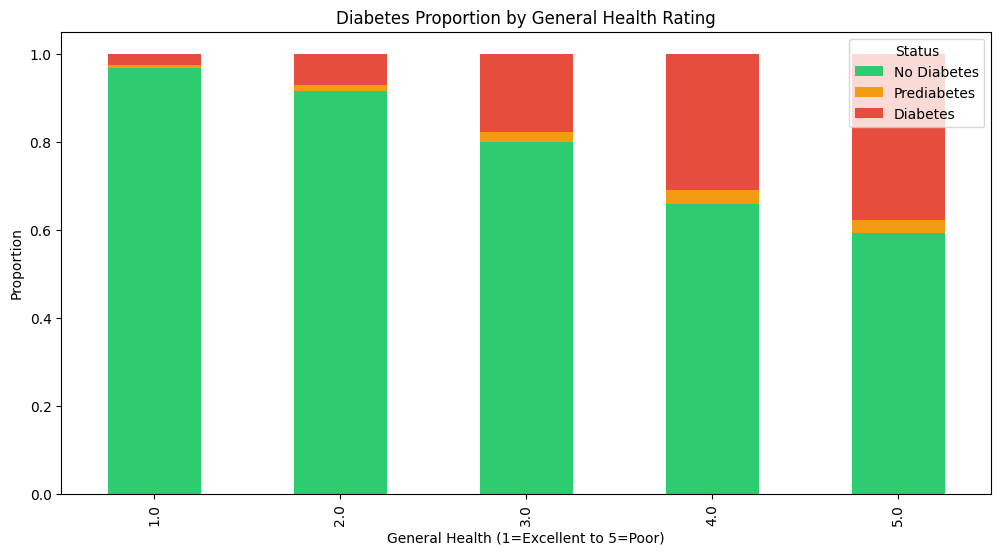

In [20]:
# Diabetes prevalence by General Health Rating
plt.figure(figsize=(10, 6))
cross_tab = pd.crosstab(df['GenHlth'], df['Diabetes_012'], normalize='index')
cross_tab.plot(kind='bar', stacked=True, color=['#2ecc71', '#f39c12', '#e74c3c'], figsize=(12, 6))
plt.title('Diabetes Proportion by General Health Rating')
plt.xlabel('General Health (1=Excellent to 5=Poor)')
plt.ylabel('Proportion')
plt.legend(['No Diabetes', 'Prediabetes', 'Diabetes'], title='Status')
plt.show()

<Figure size 1200x600 with 0 Axes>

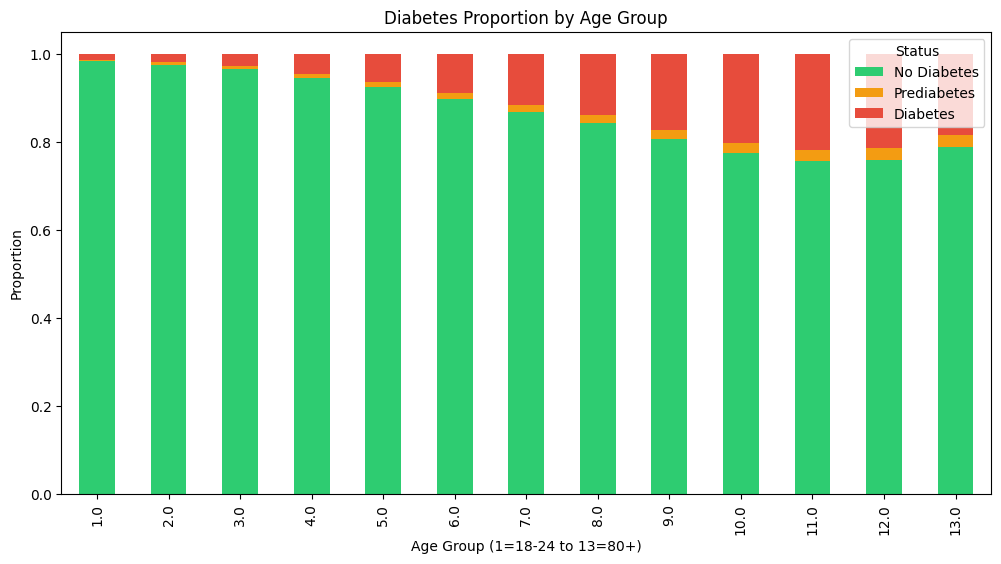

In [21]:
# Diabetes prevalence by Age Group
plt.figure(figsize=(12, 6))
cross_tab_age = pd.crosstab(df['Age'], df['Diabetes_012'], normalize='index')
cross_tab_age.plot(kind='bar', stacked=True, color=['#2ecc71', '#f39c12', '#e74c3c'], figsize=(12, 6))
plt.title('Diabetes Proportion by Age Group')
plt.xlabel('Age Group (1=18-24 to 13=80+)')
plt.ylabel('Proportion')
plt.legend(['No Diabetes', 'Prediabetes', 'Diabetes'], title='Status')
plt.show()

## 2.4 Verify Data Quality

In [22]:
# Missing values
print(f"Missing values: {df.isnull().sum().sum()}")

# Duplicates
dups = df.duplicated().sum()
print(f"Duplicate rows: {dups:,} ({dups/len(df)*100:.1f}%)")

# Value ranges
print(f"\nValue range checks:")
print(f"  BMI: {df['BMI'].min():.0f}-{df['BMI'].max():.0f} (expected ~12-98)")
print(f"  Age: {int(df['Age'].min())}-{int(df['Age'].max())} (expected 1-13)")
print(f"  GenHlth: {int(df['GenHlth'].min())}-{int(df['GenHlth'].max())} (expected 1-5)")

# Binary validation
print(f"\nBinary features all 0/1: {all(set(df[f].unique()) <= {0, 1, 0.0, 1.0} for f in binary_features)}")

Missing values: 0
Duplicate rows: 23,899 (9.4%)

Value range checks:
  BMI: 12-98 (expected ~12-98)
  Age: 1-13 (expected 1-13)
  GenHlth: 1-5 (expected 1-5)

Binary features all 0/1: True


## 2.5 Outlier Checks

Quick screening for implausible or extreme values to avoid skewing summaries and models.

In [23]:
# Outlier screening
outlier_report = {}

# BMI extremes
q99_bmi = df['BMI'].quantile(0.999)
outlier_report['BMI'] = {
    'min': float(df['BMI'].min()),
    'max': float(df['BMI'].max()),
    'q99': float(q99_bmi),
    'n_above_q99': int((df['BMI'] > q99_bmi).sum())
}

# MentHlth / PhysHlth at max (30 days)
for feat in ['MentHlth', 'PhysHlth']:
    n_max = int((df[feat] == 30).sum())
    pct_max = (df[feat] == 30).mean() * 100
    outlier_report[feat] = {
        'n_at_30_days': n_max,
        'pct_at_30_days': pct_max
    }

print("Outlier summary (top-line checks):")
for k, v in outlier_report.items():
    print(f"\n{k}:")
    for kk, vv in v.items():
        print(f"  {kk}: {vv}")

# Inspect top BMI cases for sanity
extreme_bmi = df[df['BMI'] > q99_bmi][['BMI', target]].head(10)
print("\nSample of highest BMI records (top 0.1%):")
print(extreme_bmi)


Outlier summary (top-line checks):

BMI:
  min: 12.0
  max: 98.0
  q99: 81.0
  n_above_q99: 230

MentHlth:
  n_at_30_days: 12088
  pct_at_30_days: 4.765058341217281

PhysHlth:
  n_at_30_days: 19400
  pct_at_30_days: 7.647429832860296

Sample of highest BMI records (top 0.1%):
        BMI  Diabetes_012
11614  85.0           2.0
18415  82.0           0.0
19816  92.0           2.0
33839  88.0           0.0
36324  96.0           1.0
69818  82.0           0.0
76313  87.0           0.0
76315  89.0           0.0
76317  92.0           0.0
76324  87.0           0.0


BMI values range from 12 to 98. Extreme values are retained as they may represent genuine severe obesity, BRFSS self-report noise is expected, and downstream models use categorical binning which absorbs extremes.

| Dimension | Status | Notes |
|-----------|--------|-------|
| Completeness | Pass | No missing values |
| Validity | Pass | All values within expected ranges |
| Consistency | Pass | Binary features correctly encoded |
| Uniqueness | Note | 23,899 duplicates (9.4%) — retained as distinct respondents with identical categorical profiles |

The data is clean and suitable for modelling.

## Summary

The dataset is clean and suitable for modelling. Key findings:
1. **Class imbalance**: Prediabetes at 1.8% is the primary modelling challenge
2. **Predictive signal**: Concentrated in GenHlth, HighBP, BMI, DiffWalk, HighChol, and Age
3. **Collinearity**: Health perception, SES, and mobility variables overlap — informs feature engineering
4. **Counterintuitive associations**: HvyAlcoholConsump (survivorship bias), Stroke/HeartDiseaseorAttack (reverse causality) flagged for exclusion